In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
directory = '../data/'
output_dir = '../data/csv_grouped_data'

In [36]:
filename_ibex ="../data/grouped_data_day_mean_full_tweets_sentiment_ngrams_ibex35.csv"
filename_ibex_prices ="../data/bolsas_ibex_2010-2021.csv"
filename_precios_bolsa = "../data/bolsas_es_mad_2010-2021.csv"
filename_asoc = "../data/grouped_data_day_mean_full_tweets_sentiment_ngrams_asociaciones_empresariales.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_ibex = pd.read_csv(filename_ibex, sep=";")
df_ibex_prices = pd.read_csv(filename_ibex_prices, sep=";")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_asoc['normalised_date'] = pd.to_datetime(df_asoc['normalised_date'], errors='coerce')
df_asoc['normalised_date'] = df_asoc['normalised_date'].dt.normalize()
df_ibex['normalised_date'] = pd.to_datetime(df_ibex['normalised_date'], errors='coerce')
df_ibex['normalised_date'] = df_ibex['normalised_date'].dt.normalize()


df_ibex_prices['Dates'] = pd.to_datetime(df_ibex_prices['Dates'], errors='coerce')
df_ibex_prices['Dates'] = df_ibex_prices['Dates'].dt.normalize()

df_precios_bolsa['Dates'] = pd.to_datetime(df_precios_bolsa['Dates'], errors='coerce')
df_precios_bolsa['Dates'] = df_precios_bolsa['Dates'].dt.normalize()

df_ibex_prices.rename(columns = {'LAST_PRICE':'Close', 'Dates': 'Date'}, inplace = True)


In [37]:
df_x = pd.merge(left=df_asoc, right=df_ibex, left_on='normalised_date', right_on='normalised_date')
df_total = pd.merge(left=df_x, right=df_ibex_prices, left_on='normalised_date', right_on='Date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_ibex"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_ibex", "Close"]]
df_total

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

     normalised_date  sentiment_asociacones  sentiment_ibex    Close
0         2010-01-04               0.180934        0.163938  12145.1
1         2010-01-05               0.083857        0.206305  12204.4
2         2010-01-07               0.416657        0.188553  12166.3
3         2010-01-08               0.026698        0.192648  12163.0
4         2010-01-12               0.015352        0.307515  11966.1
...              ...                    ...             ...      ...
2848      2020-12-28               0.252183        0.104485   8155.6
2849      2020-12-29               0.238587        0.138290   8174.8
2850      2020-12-30               0.223283        0.116739   8154.4
2851      2020-12-31               0.354437        0.102232   8073.7
2852      2021-01-01               0.563693        0.220672   8073.7

[2853 rows x 4 columns]

In [38]:
df_precios_bolsa.rename(columns = {'PX_VOLUME':'price_change', 'Dates': 'date'}, inplace = True)
df_precios_bolsa = df_precios_bolsa[["date", "price_change"]]
df_precios_bolsa["date"]= pd.to_datetime(df_precios_bolsa["date"]) 
df_total = pd.merge(left=df_total, right=df_precios_bolsa, left_on='normalised_date', right_on='date')

df_total.sentiment_asociacones = df_total.sentiment_asociacones
df_total.sentiment_ibex = df_total.sentiment_ibex
df_total.Close = df_total.Close.diff()
df_total = df_total.rename(columns={"Close": "ibex_change", "price_change": "madrid_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float).diff()
df_total['sentiment_ibex'] = df_total['sentiment_ibex'].astype(float).diff()
df_total['ibex_change'] = df_total['ibex_change'].astype(float)
df_total['madrid_change'] = df_total['madrid_change'].astype(float)

df_total = df_total.dropna()
df_total = df_total[['normalised_date','sentiment_asociacones', 'sentiment_ibex', 'madrid_change']]
df_total.to_csv("df_total_es.csv", sep=";")

df_total_no_covid = df_total.copy()
df_total_no_covid = df_total_no_covid[:-100]
df_total_no_covid



AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

     normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
1         2010-01-05              -0.097076        0.042367      5609429.0
2         2010-01-07               0.332799       -0.017752      4437052.0
3         2010-01-08              -0.389959        0.004095      7055585.0
4         2010-01-12              -0.011345        0.114867      8045666.0
5         2010-01-14               0.259258       -0.124711      9471771.0
...              ...                    ...             ...            ...
2748      2020-08-10               0.015207        0.002624     18646504.0
2749      2020-08-11               0.073991       -0.014380     18646504.0
2750      2020-08-12              -0.067574       -0.015768     18646504.0
2751      2020-08-13              -0.072786        0.049261     18646504.0
2752      2020-08-14               0.117330       -0.028102     18646504.0

[2752 rows x 4 columns]

In [49]:
from statsmodels.tsa.stattools import grangercausalitytests

start_date = "2020-01-10 00:00:00.000"
end_date = "2020-05-01 00:00:00.000"

mask = (df_total['normalised_date'] > start_date) & (df_total['normalised_date'] <= end_date)
df_restricted = df_total.copy()
df_restricted = df_restricted.loc[mask]
print(df_restricted[['sentiment_ibex','madrid_change']])


granger_test = sm.tsa.stattools.grangercausalitytests(df_total[['sentiment_ibex','madrid_change']].values, maxlag=30, addconst=True, verbose=True)
granger_test


'''
Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2970  , p=0.0111  , df_denom=2821, df_num=10
ssr based chi2 test:   chi2=23.1410 , p=0.0102  , df=10
likelihood ratio test: chi2=23.0473 , p=0.0106  , df=10
parameter F test:         F=2.2970  , p=0.0111  , df_denom=2821, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.8911  , p=0.0360  , df_denom=2818, df_num=11
ssr based chi2 test:   chi2=20.9718 , p=0.0337  , df=11
likelihood ratio test: chi2=20.8948 , p=0.0345  , df=11
parameter F test:         F=1.8911  , p=0.0360  , df_denom=2818, df_num=11

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2970  , p=0.0111  , df_denom=2821, df_num=10
ssr based chi2 test:   chi2=23.1410 , p=0.0102  , df=10
likelihood ratio test: chi2=23.0473 , p=0.0106  , df=10
parameter F test:         F=2.2970  , p=0.0111  , df_denom=2821, df_num=10
'''

      sentiment_ibex  madrid_change
2598       -0.007590     18646504.0
2599       -0.062687     18646504.0
2600        0.063971     18646504.0
2601        0.023267     18646504.0
2602       -0.040012     18646504.0
...              ...            ...
2673       -0.010174     18646504.0
2674        0.013892     18646504.0
2675       -0.007661     18646504.0
2676        0.035951     18646504.0
2677       -0.006826     18646504.0

[80 rows x 2 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2619  , p=0.6088  , df_denom=2848, df_num=1
ssr based chi2 test:   chi2=0.2622  , p=0.6086  , df=1
likelihood ratio test: chi2=0.2622  , p=0.6086  , df=1
parameter F test:         F=0.2619  , p=0.6088  , df_denom=2848, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1499  , p=0.3168  , df_denom=2845, df_num=2
ssr based chi2 test:   chi2=2.3039  , p=0.3160  , df=2
likelihood ratio test: chi2=2.3030  , p=0.3162  , df=2
parameter F

{1: ({'ssr_ftest': (0.2619446194732614, 0.6088269927144296, 2848.0, 1),
   'ssr_chi2test': (0.2622205442830998, 0.6085986990500504, 1),
   'lrtest': (0.26220848616139847, 0.6086069389550707, 1),
   'params_ftest': (0.2619446194741204, 0.6088269927139973, 2848.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.149936929590467, 0.3168038772554591, 2845.0, 2),
   'ssr_chi2test': (2.303915816754187, 0.31601743009842126, 2),
   'lrtest': (2.3029850853199605, 0.31616452800090494, 2),
   'params_ftest': (1.1499354724200666, 0.31680433852015705, 2845.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.6693794801244544, 0.5707930094648144, 2842.0, 3),
   'ssr_chi2test': (2.013084594167386, 0.5696953945146577, 3),
   'lrtest': (2.0123737128742505, 0.5698424703207385, 3),
   'params_ftest': (0.6693794162656674, 0.5707930491287169, 2842.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

In [52]:
from statsmodels.tsa.stattools import grangercausalitytests

start_date = "2020-01-10 00:00:00.000"
end_date = "2020-05-01 00:00:00.000"

mask = (df_total['normalised_date'] > start_date) & (df_total['normalised_date'] <= end_date)
df_restricted = df_total.copy()
df_restricted = df_restricted.loc[mask]
print(df_restricted)


granger_test = sm.tsa.stattools.grangercausalitytests(df_total[['sentiment_asociacones','madrid_change']], maxlag=20, verbose=True)
granger_test


'''
Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8171  , p=0.0934  , df_denom=2848, df_num=1
ssr based chi2 test:   chi2=2.8201  , p=0.0931  , df=1
likelihood ratio test: chi2=2.8187  , p=0.0932  , df=1
parameter F test:         F=2.8171  , p=0.0934  , df_denom=2848, df_num=1
'''

     normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
2598      2020-01-13               0.154907       -0.007590     18646504.0
2599      2020-01-14              -0.037317       -0.062687     18646504.0
2600      2020-01-15              -0.059082        0.063971     18646504.0
2601      2020-01-16              -0.049738        0.023267     18646504.0
2602      2020-01-17               0.027810       -0.040012     18646504.0
...              ...                    ...             ...            ...
2673      2020-04-27              -0.078744       -0.010174     18646504.0
2674      2020-04-28              -0.017852        0.013892     18646504.0
2675      2020-04-29               0.023493       -0.007661     18646504.0
2676      2020-04-30              -0.008973        0.035951     18646504.0
2677      2020-05-01              -0.083297       -0.006826     18646504.0

[80 rows x 4 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8

{1: ({'ssr_ftest': (2.817110137831626, 0.09337388880138746, 2848.0, 1),
   'ssr_chi2test': (2.8200775993532186, 0.09309190272820655, 1),
   'lrtest': (2.818683773122757, 0.09317277899943353, 1),
   'params_ftest': (2.817110137831742, 0.09337388880138746, 2848.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.6626467578955026, 0.1898206031504466, 2845.0, 2),
   'ssr_chi2test': (3.3311376168732396, 0.1890830753394502, 2),
   'lrtest': (3.3291923819851945, 0.1892670703007446, 2),
   'params_ftest': (1.6626456856955936, 0.18982080643856505, 2845.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7980739469431436, 0.494820590925909, 2842.0, 3),
   'ssr_chi2test': (2.4001189389595523, 0.49361248264576496, 3),
   'lrtest': (2.399108525190968, 0.4938005920419519, 3),
   'params_ftest': (0.7980738141816089, 0.4948206651546315, 2842.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

In [54]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model = VAR(df_total[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results = model.fit(maxlags=15, ic='aic')

# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model_restricted = VAR(df_total_no_covid[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results_restricted = model.fit(maxlags=15, ic='aic')
results.summary()
results_restricted.summary()

/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Feb, 2021
Time:                     13:17:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    22.8950
Nobs:                     2837.00    HQIC:                   22.7100
Log likelihood:          -44004.6    FPE:                6.56873e+09
AIC:                      22.6056    Det(Omega_mle):     6.25930e+09
--------------------------------------------------------------------
Results for equation sentiment_asociacones
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.003163         0.002570           -1.231           0.218
L1.sentiment_asociacones         -0.878772         0.019019          -46.205           0.

In [55]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model_no_covid = VAR(df_total_no_covid[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results_no_covid = model_no_covid.fit(maxlags=15, ic='aic')
results_no_covid.summary()

/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Feb, 2021
Time:                     13:18:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    22.9666
Nobs:                     2737.00    HQIC:                   22.7762
Log likelihood:          -42534.6    FPE:                6.99457e+09
AIC:                      22.6684    Det(Omega_mle):     6.65343e+09
--------------------------------------------------------------------
Results for equation sentiment_asociacones
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.003241         0.002582           -1.255           0.209
L1.sentiment_asociacones         -0.881630         0.019291          -45.702           0.

In [56]:

# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [63]:
lag_order = results.k_ar
print(df_total_no_covid)
train_x = create_window_data_arrays((df_total_no_covid.sentiment_asociacones,df_total_no_covid.sentiment_ibex, df_total_no_covid.madrid_change), lag_order)
print(train_x.shape)
print(train_x[-1])
print("----")

print(df_total_no_covid.values[-1])
print("----")
print(results.forecast(train_x[-1], 1))


     normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
1         2010-01-05              -0.097076        0.042367      5609429.0
2         2010-01-07               0.332799       -0.017752      4437052.0
3         2010-01-08              -0.389959        0.004095      7055585.0
4         2010-01-12              -0.011345        0.114867      8045666.0
5         2010-01-14               0.259258       -0.124711      9471771.0
...              ...                    ...             ...            ...
2748      2020-08-10               0.015207        0.002624     18646504.0
2749      2020-08-11               0.073991       -0.014380     18646504.0
2750      2020-08-12              -0.067574       -0.015768     18646504.0
2751      2020-08-13              -0.072786        0.049261     18646504.0
2752      2020-08-14               0.117330       -0.028102     18646504.0

[2752 rows x 4 columns]
(2737, 15, 3)
[[-2.09582613e-02 -2.19285040e-02  1.86465040e+07]
 [ 8.44038

In [58]:
lag_order_restricted = results_restricted.k_ar
train_x_restricted = create_window_data_arrays((df_restricted.sentiment_asociacones,df_restricted.sentiment_ibex, df_restricted.madrid_change), lag_order_restricted)


In [62]:
results.forecast(train_x[0], 1)
forecasted = np.array([list(results.forecast(train_x[i], 1)[0]) for i in range(0,train_x.shape[0])])
print(forecasted[-1])

print(df_total.values.shape)
print(forecasted.shape)

# while using one ts
#y_pred = forecasted[:,1:]
y_pred = forecasted[:,2:]
y_train = df_total_no_covid.madrid_change.values[lag_order:]

M = np.column_stack((y_train, y_pred))

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(forecasted, y_pred))


print(M)
plt.plot(M[-200:])

[-1.11185398e-02  1.47321152e-03  2.10160345e+07]
(2852, 4)
(2737, 3)


ValueError: y_true and y_pred have different number of output (3!=1)

2891048.2953496343
[[18646504.         18748684.05671271]
 [18646504.         16404406.24982516]
 [18646504.         18620534.41840258]
 [18646504.         17016978.16910327]
 [18646504.         19212600.21069785]
 [18646504.         20359513.67910814]
 [18646504.         12571340.31195073]
 [18646504.         15091481.50841171]
 [18646504.         17204988.88541998]
 [18646504.         14998510.02916525]
 [18646504.         17179963.02396494]
 [18646504.         16809337.20210157]
 [18646504.         18303410.31682465]
 [18646504.         13457918.25661925]
 [18646504.         15728257.14495304]
 [18646504.         19708062.54860148]
 [18646504.         15023130.19138984]
 [18646504.         15313180.73896657]
 [18646504.         20005186.70882376]
 [18646504.         13927636.80677434]
 [18646504.         18930641.83093939]
 [18646504.          9725351.81660002]
 [18646504.         14958048.70381922]
 [18646504.         12071584.42942732]
 [18646504.          9526007.1544116 ]
 [1864

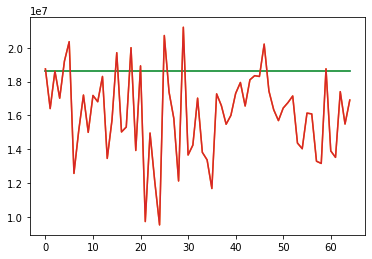

In [60]:
results_restricted.forecast(train_x[0], 1)
forecasted = np.array([list(results_restricted.forecast(train_x_restricted[i], 1)[0]) for i in range(0,train_x_restricted.shape[0])])

y_pred = forecasted[:,2:]
y_train = df_restricted.madrid_change.values[lag_order_restricted:]

M = np.column_stack((y_train, y_pred))

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_train, y_pred))


print(M)
plt.plot(M[-200:])
print(M)
plt.plot(M[-200:])

In [61]:
# Split data
nobs = 4
df_train, df_test = df_total[0:-nobs], df_total[-nobs:]
# Check for stationarity with Augmented Dickey-Fuller Test (ADF Test)
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller

def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

#apply adf test on the series
adf_test(df_train["sentiment_asociacones"])
adf_test(df_train["sentiment_ibex"])
adf_test(df_train["madrid_change"])

Test Statistic         -1.574850e+01
p-value                 1.231430e-28
# Lags                  2.800000e+01
# Observations          2.819000e+03
Critical Value (1%)    -3.432672e+00
Critical Value (5%)    -2.862566e+00
Critical Value (10%)   -2.567316e+00
dtype: float64
 Series is Stationary
Test Statistic         -1.556871e+01
p-value                 1.999458e-28
# Lags                  2.400000e+01
# Observations          2.823000e+03
Critical Value (1%)    -3.432669e+00
Critical Value (5%)    -2.862564e+00
Critical Value (10%)   -2.567315e+00
dtype: float64
 Series is Stationary
Test Statistic           -52.197507
p-value                    0.000000
# Lags                     0.000000
# Observations          2847.000000
Critical Value (1%)       -3.432649
Critical Value (5%)       -2.862556
Critical Value (10%)      -2.567311
dtype: float64
 Series is Stationary
